In [1]:
from __future__ import division, print_function
import numpy as np
from collections import OrderedDict
import logging

from IPython.display import display
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from astropy.io import fits
import astropy.wcs
from astropy import coordinates
import astropy.units as apu
from astropy import table

import astropyp
from astropyp.wrappers.astromatic import ldac
from astropyp.phot import stack
import bd_search

alogger = logging.getLogger('astropyp')
alogger.setLevel(logging.INFO)

idx_connect = 'sqlite:////media/data-beta/users/fmooleka/decam/decam.db'
ref_path = '/media/data-beta/users/fmooleka/decam/catalogs/ref/'

# SExtractor 'extract' detection parameters
conv_filter = np.load('/media/data-beta/users/fmooleka/2016decam/5x5gauss.npy')
sex_params = {
    'extract': {
        'thresh': 40,
        #'err':,
        'minarea': 3, # default
        'conv': conv_filter,
        #'deblend_nthresh': 32, #default
        'deblend_cont': 0.001,
        #'clean': True, #default
        #'clean_param': 1 #default
    },
    'kron_k': 2.5,
    'kron_min_radius': 3.5,
    'filter': conv_filter,
    #'thresh': 1.5 # *bkg.globalrms
}

obj='F100'
refname = '2MASS'
#refname = 'UCAC4'
fullref = ldac.get_table_from_ldac(ref_path+'{0}-{1}.fits'.format(obj, refname))

In [2]:
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

def get_exp_files(expnum, night, filtr, idx_connect):
    sql = 'select * from decam_obs where expnum={0} and filter like "{1}%" and dtcaldat="{2}"'.format(
        expnum, filtr, night)
    exp_info = astropyp.db_utils.index.query(sql, idx_connect)
    img_filename = exp_info[exp_info['PRODTYPE']=='image'][0]['filename']
    img = fits.open(img_filename)
    dqmask_filename = exp_info[exp_info['PRODTYPE']=='dqmask'][0]['filename']
    dqmask = fits.open(dqmask_filename)
    return img, dqmask
  
min_flux = 1000
min_amplitude = 1000
good_amplitude = 50
calibrate_amplitude = 200
frame = 1
explist = [442433, 442434, 442435]
aper_radius = 8

ccds = []

for expnum in explist:
    #img, dqmask = get_exp_files(expnum, "2015-05-26", "i", idx_connect)
    img, dqmask = get_exp_files(expnum, "2015-05-26", "z", idx_connect)
    header = img[frame].header
    wcs = astropy.wcs.WCS(header)
    img_data = img[frame].data
    dqmask_data = dqmask[frame].data
    ccd = astropyp.phot.phot.SingleImage(header, img_data, dqmask_data,
        wcs=wcs, gain=4., exptime=30, aper_radius=aper_radius)
    ccds.append(ccd)

In [3]:
ccd_stack = stack.Stack(ccds, 1)
ccd_stack.detect_sources(min_flux=min_flux, good_amplitude=good_amplitude,
    calibrate_amplitude=calibrate_amplitude, psf_amplitude=1000, sex_params=sex_params, 
    subtract_bkg=True, windowed=False)
ccd_stack.get_transforms()

INFO:astropyp.phot.psf:Total sources: 1099
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 757
INFO:astropyp.phot.psf:Sources with bad pixels: 205
INFO:astropyp.phot.psf:Elliptical sources: 81
INFO:astropyp.phot.psf:Source with close neighbors: 230
INFO:astropyp.phot.psf:Sources near an edge: 18
INFO:astropyp.phot.psf:Sources after cuts: 200
INFO:astropyp.phot.psf:Total sources: 1024
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 733
INFO:astropyp.phot.psf:Sources with bad pixels: 181
INFO:astropyp.phot.psf:Elliptical sources: 72
INFO:astropyp.phot.psf:Source with close neighbors: 193
INFO:astropyp.phot.psf:Sources near an edge: 15
INFO:astropyp.phot.psf:Sources after cuts: 173
INFO:astropyp.phot.psf:Total sources: 1134
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 785
INFO:astropyp.phot.psf:Sources with bad pixels: 246
INFO:astropy

In [244]:
def stack_full_images(imgs, ref_index, tx_solutions, dqmasks = None,
            combine_method='mean', dqmask_min=0, bad_pix_val=1,
            buf=10, order=3):
    from scipy import interpolate
    from astropy.nddata import extract_array, overlap_slices
    from astropyp.astrometry import ImageSolution
    
    buf = float(buf)
    
    # Get the minimum size of the final stack by projecting all of
    # the images onto the reference frame
    img_x = np.arange(0, imgs[ref_index].shape[1], 1)
    img_y = np.arange(0, imgs[ref_index].shape[0], 1)
    xmin = img_x[0]-buf
    xmax = img_x[-1]+buf
    ymin = img_y[0]-buf
    ymax = img_y[-1]+buf
    for n in range(len(imgs)):
        if n!=ref_index:
            tx_x,tx_y = tx_solutions[n].transform_coords(
                x=[img_x[0], img_x[-1]],
                y=[img_y[0], img_y[-1]])
            if tx_x[0]<xmin:
                xmin = tx_x[0]
            if tx_x[1]>xmax:
                xmax = tx_x[1]
            if tx_y[0]<ymin:
                ymin = tx_y[0]
            if tx_y[1]>ymax:
                ymax = tx_y[1]
    x_tx = OrderedDict([('Intercept', xmin), ('A_1_0', 1.0), ('A_0_1', 0.0)])
    y_tx = OrderedDict([('Intercept', ymin), ('B_1_0', 1.0), ('B_0_1', 0.0)])
    
    # Modify the tx solutions to fit the coadd
    for n in range(len(imgs)):
        if n!= ref_index:
            new_x_tx = tx_solutions[n].x_tx.copy()
            new_y_tx = tx_solutions[n].y_tx.copy()
            new_x_tx['Intercept'] += xmin
            new_y_tx['Intercept'] += ymin
            tx_solutions[n] = ImageSolution(x_tx=new_x_tx, y_tx=new_y_tx,
                order=tx_solutions[n].order)
        else:
            tx_solutions[n] = ImageSolution(x_tx=x_tx, y_tx=y_tx, order=1)
    
    coadd_x = np.arange(0, xmax-xmin, 1)
    coadd_y = np.arange(0, ymax-ymin, 1)
    Xc, Yc = np.meshgrid(coadd_x, coadd_y)
    patches = []
    # Reproject each image to the coadded image
    for n in range(len(imgs)):
            tx_x,tx_y = tx_solutions[n].transform_coords(
                x=Xc.flatten(),y=Yc.flatten())
            tx_x = np.array(tx_x).reshape(Xc.shape)
            tx_y = np.array(tx_y).reshape(Yc.shape)
            img_x = np.arange(0, imgs[n].shape[1], 1)
            img_y = np.arange(0, imgs[n].shape[0], 1)
            # Create an interpolating function and reproject the image
            data_func = interpolate.RectBivariateSpline(img_y, img_x, 
                imgs[n],kx=order,ky=order)
            continue
            patch = data_func(tx_y.flatten(), tx_x.flatten(), grid=False)
            patch = patch.reshape(Xc.shape)
            #Create the dqmask
            if dqmasks is not None:
                points = (img_y, img_x)
                values = dqmasks[n]
                dq_func = interpolate.RegularGridInterpolator(
                    points, values, method='nearest', 
                    fill_value=bad_pix_val, bounds_error=False)
                dqmask = dq_func(zip(tx_y.flatten(),tx_x.flatten()))
                dqmask = dqmask.reshape(Xc.shape)
                dqmask = dqmask.astype(bool)
            else:
                dqmask = None
            
            # Apply the dqmask to the image
            patch[dqmask>dqmask_min] = np.nan
            patch[dqmask>dqmask_min] 
            patch = np.ma.array(patch)
            patch.mask = np.isnan(patch)
            
            patches.append(patch)
    return None,None,None
    stack = np.ma.mean(patches, axis=0)
    dqmask = patches[0].mask
    for n in range(1,len(patches)):
        dqmask = np.bitwise_and(dqmask, patches[n].mask)
    return stack, dqmask, patches

#imgs = [ccd.img for ccd in ccd_stack.ccds]
#dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
imgs = [ccd.img[:200,:100] for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask[:200,:100] for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]
stack, dqmask, patches = stack_full_images(imgs, 1, tx_solutions, dqmasks)

In [5]:
imgs = [ccd.img[:200,:100] for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask[:200,:100] for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]
stack, dqmask, patches = astropyp.phot.stack.stack_full_images(imgs, 1, tx_solutions, dqmasks, pool_size=1)

2251.49341872


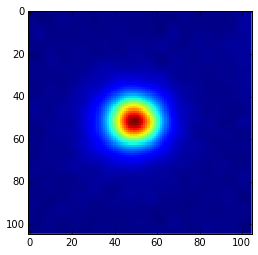

In [26]:
img = astropyp.utils.misc.extract_array(stack, (21,21), (183, 68), subsampling=5)
print(np.max(img))
#plt.imshow(stack[173:193,58:78], interpolation='none')
plt.imshow(img, interpolation='none')
plt.show()

In [246]:
imgs = [ccd.img for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]
%time stack, dqmask, patches = stack_full_images(imgs, 1, tx_solutions, dqmasks)

CPU times: user 7.33 s, sys: 9.26 s, total: 16.6 s
Wall time: 16.6 s


In [243]:
imgs = [ccd.img[:1000,:500] for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask[:1000,:500] for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]
%time stack, dqmask, patches = stack_full_images(imgs, 1, tx_solutions, dqmasks)

CPU times: user 5.56 s, sys: 148 ms, total: 5.71 s
Wall time: 5.7 s


In [216]:
imgs = [ccd.img for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]

%time stack, dqmask, patches=stack_full_images(imgs, 1, tx_solutions, dqmasks, order=5)

CPU times: user 4min 2s, sys: 19.6 s, total: 4min 21s
Wall time: 4min 22s


In [219]:
imgs = [ccd.img for ccd in ccd_stack.ccds]
dqmasks = [ccd.dqmask for ccd in ccd_stack.ccds]
tx_solutions = [ccd_stack.tx_solutions[(1,0)], None, ccd_stack.tx_solutions[(1,2)]]

%time stack, dqmask, patches=stack_full_images(imgs, 1, tx_solutions, dqmasks, order=3)

CPU times: user 3min 56s, sys: 20.1 s, total: 4min 16s
Wall time: 4min 17s


In [228]:
stk = stack.filled(0)

INFO:astropyp.phot.psf:Total sources: 1060
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 731
INFO:astropyp.phot.psf:Sources with bad pixels: 67
INFO:astropyp.phot.psf:Elliptical sources: 100
INFO:astropyp.phot.psf:Source with close neighbors: 234
INFO:astropyp.phot.psf:Sources near an edge: 0
INFO:astropyp.phot.psf:Sources after cuts: 218
/media/data-beta/users/fmooleka/anaconda/envs/pyp27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


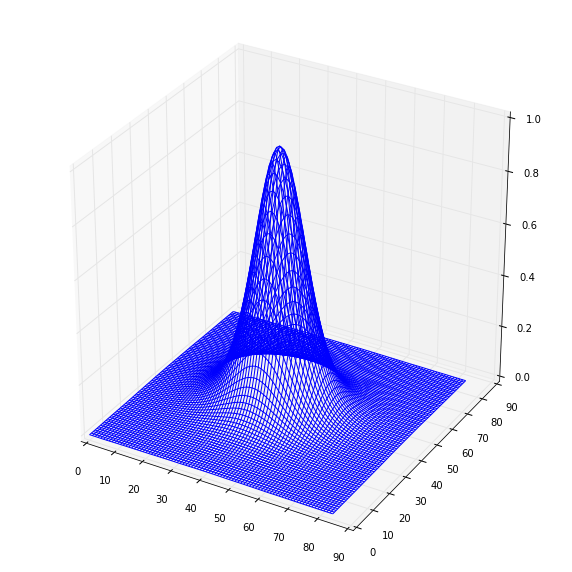

In [229]:
max_offset=3
ccd = astropyp.phot.phot.SingleImage(
    img=stk, dqmask=dqmask, gain=4., exptime=30, aper_radius=8)
ccd.detect_sources(sex_params, subtract_bkg=True)
ccd.select_psf_sources(min_flux, min_amplitude, edge_dist=aper_radius+max_offset)
psf_array = ccd.create_psf()
ccd.show_psf()
good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
#good_idx = ccd.catalog.sources['peak']>good_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
result = ccd.perform_psf_photometry(indices=good_idx)

In [230]:
good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
good_idx = good_idx & np.isfinite(ccd.catalog.sources['psf_mag'])
good_sources = ccd.catalog.sources[good_idx]

print('rms', np.sqrt(np.sum(good_sources['psf_mag_err']**2/len(good_sources))))
print('mean', np.mean(good_sources['psf_mag_err']))
print('median', np.median(good_sources['psf_mag_err']))
print('stddev', np.std(good_sources['psf_mag_err']))

bad_count = np.sum(good_sources['psf_mag_err']>.05)
print('bad psf error: {0}, or {1}%'.format(bad_count, bad_count/len(good_sources)*100))
print('Better than 5%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.05), len(good_sources)))
print('Better than 2%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.02), len(good_sources)))
good_sources['aper_flux','psf_flux','peak','psf_mag_err'][good_sources['psf_mag_err']>.05]

rms 0.110924838381
mean 0.0295246290902
median 0.0085844350691
stddev 0.106923412062
bad psf error: 42, or 7.44680851064%
Better than 5%: 522 of 564
Better than 2%: 431 of 564


aper_flux,psf_flux,peak,psf_mag_err
float64,float64,float64,float64
32718.6280447,32800.844024,1614.94091797,0.0901980412055
29404.6796592,29257.7102171,1287.79785156,0.100246684674
4149.57246619,4309.64892041,228.196350098,0.0545071360035
17515.4961613,11205.1177083,400.415374756,0.679941313011
10473.06615,10080.6603842,459.412353516,0.136923423649
275612.835811,243963.686567,10195.3193359,0.234590552246
4008.92569463,4678.35401324,238.456207275,0.0611709714283
7520.51591616,5671.5088581,224.556243896,0.436255225402
5363.25117989,5608.56466257,276.021240234,0.0517884057386


INFO:astropyp.phot.psf:Total sources: 1062
INFO:astropyp.phot.psf:Sources with low flux: 0
INFO:astropyp.phot.psf:Sources with low amplitude: 733
INFO:astropyp.phot.psf:Sources with bad pixels: 67
INFO:astropyp.phot.psf:Elliptical sources: 103
INFO:astropyp.phot.psf:Source with close neighbors: 236
INFO:astropyp.phot.psf:Sources near an edge: 0
INFO:astropyp.phot.psf:Sources after cuts: 218


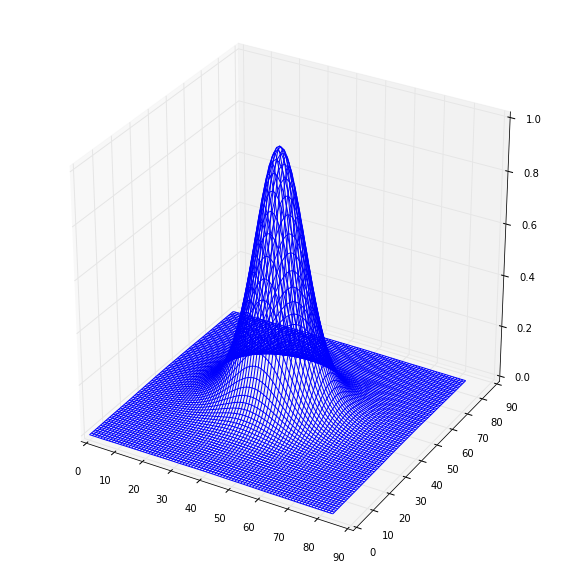

In [234]:
max_offset=3
ccd = astropyp.phot.phot.SingleImage(
    img=stk, dqmask=dqmask, gain=4., exptime=30, aper_radius=8)
ccd.detect_sources(sex_params, subtract_bkg=True)
ccd.select_psf_sources(min_flux, min_amplitude, edge_dist=aper_radius+max_offset)
psf_array = ccd.create_psf()
ccd.show_psf()
#good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
good_idx = ccd.catalog.sources['peak']>good_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
result = ccd.perform_psf_photometry(indices=good_idx)

In [235]:
#good_idx = ccd.catalog.sources['peak']>calibrate_amplitude
good_idx = ccd.catalog.sources['peak']>good_amplitude
good_idx = good_idx & (ccd.catalog.sources['pipeline_flags']==0)
good_idx = good_idx & np.isfinite(ccd.catalog.sources['psf_mag'])
good_sources = ccd.catalog.sources[good_idx]

print('rms', np.sqrt(np.sum(good_sources['psf_mag_err']**2/len(good_sources))))
print('mean', np.mean(good_sources['psf_mag_err']))
print('median', np.median(good_sources['psf_mag_err']))
print('stddev', np.std(good_sources['psf_mag_err']))

bad_count = np.sum(good_sources['psf_mag_err']>.05)
print('bad psf error: {0}, or {1}%'.format(bad_count, bad_count/len(good_sources)*100))
print('Better than 5%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.05), len(good_sources)))
print('Better than 2%: {0} of {1}'.format(np.sum(good_sources['psf_mag_err']<=.02), len(good_sources)))
good_sources['aper_flux','psf_flux','peak','psf_mag_err'][good_sources['psf_mag_err']>.05]

rms 0.186705896397
mean 0.0617909780197
median 0.0125975162371
stddev 0.176184468057
bad psf error: 134, or 17.8428761651%
Better than 5%: 617 of 751
Better than 2%: 465 of 751


aper_flux,psf_flux,peak,psf_mag_err
float64,float64,float64,float64
32699.2832833,32796.7406793,1614.8416748,0.0897324806954
29432.5133108,29264.4635328,1287.93615723,0.100935612488
2323.48287264,2733.30908804,133.225128174,0.0653819680767
3029.09186569,3039.35168081,129.792327881,0.101400727929
4202.36980429,4322.16791383,228.460952759,0.0637038946718
2135.85120922,2461.51613853,124.954048157,0.0506925116629
17491.2420349,11198.8013977,400.279418945,0.678385375172
2255.56563603,2749.23558498,136.811965942,0.0814065722753
2787.59178043,3279.94601508,167.344726562,0.0622439409945
